In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
import random

In [2]:
DATA_PATH = './Data/'

TRAIN_DATA_PATH = DATA_PATH + 'train.csv'
TEST_DATA_PATH = DATA_PATH + 'test.csv'
SUBMISSION_DATA_PATH = DATA_PATH + 'sample_submission.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
submission_df = pd.read_csv(SUBMISSION_DATA_PATH)

train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [5]:
def show_graph(col):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=train_df[f'{col}'].value_counts().index, 
                y=train_df[f'{col}'].value_counts().values, 
                palette='Set3', 
                ax=ax)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


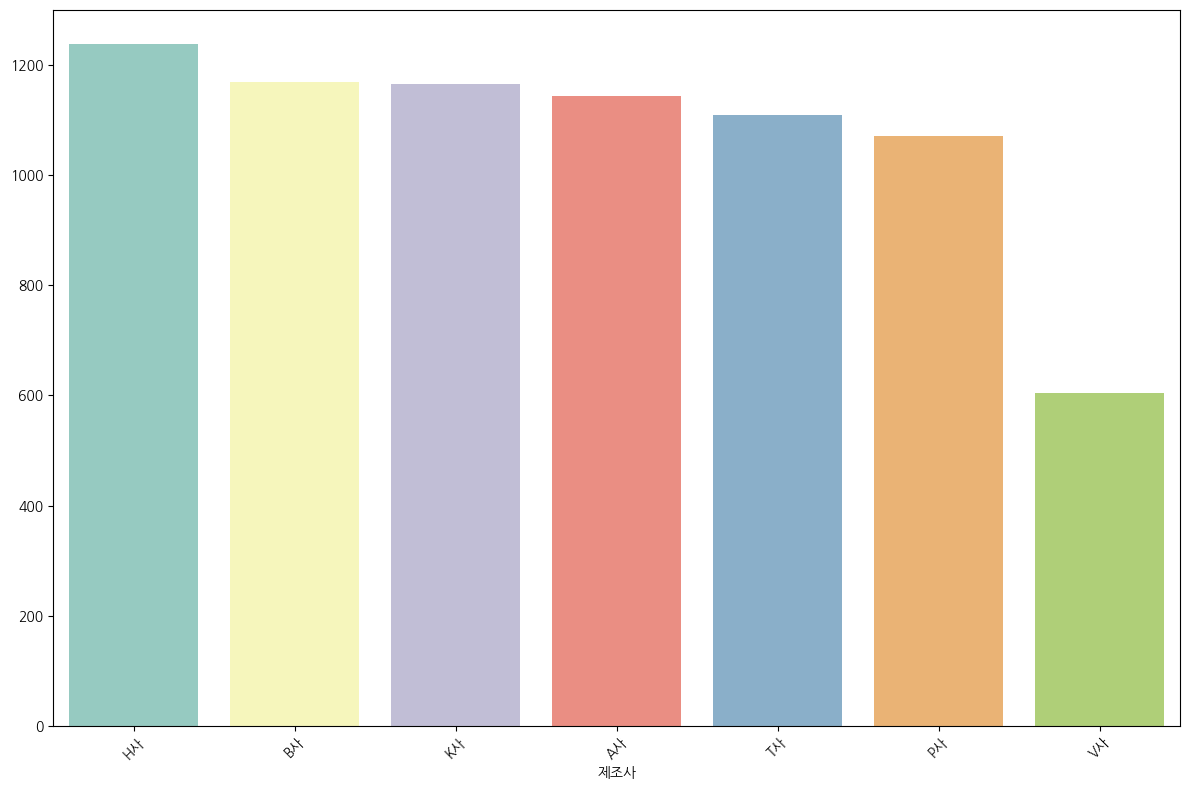

In [6]:
show_graph('제조사')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


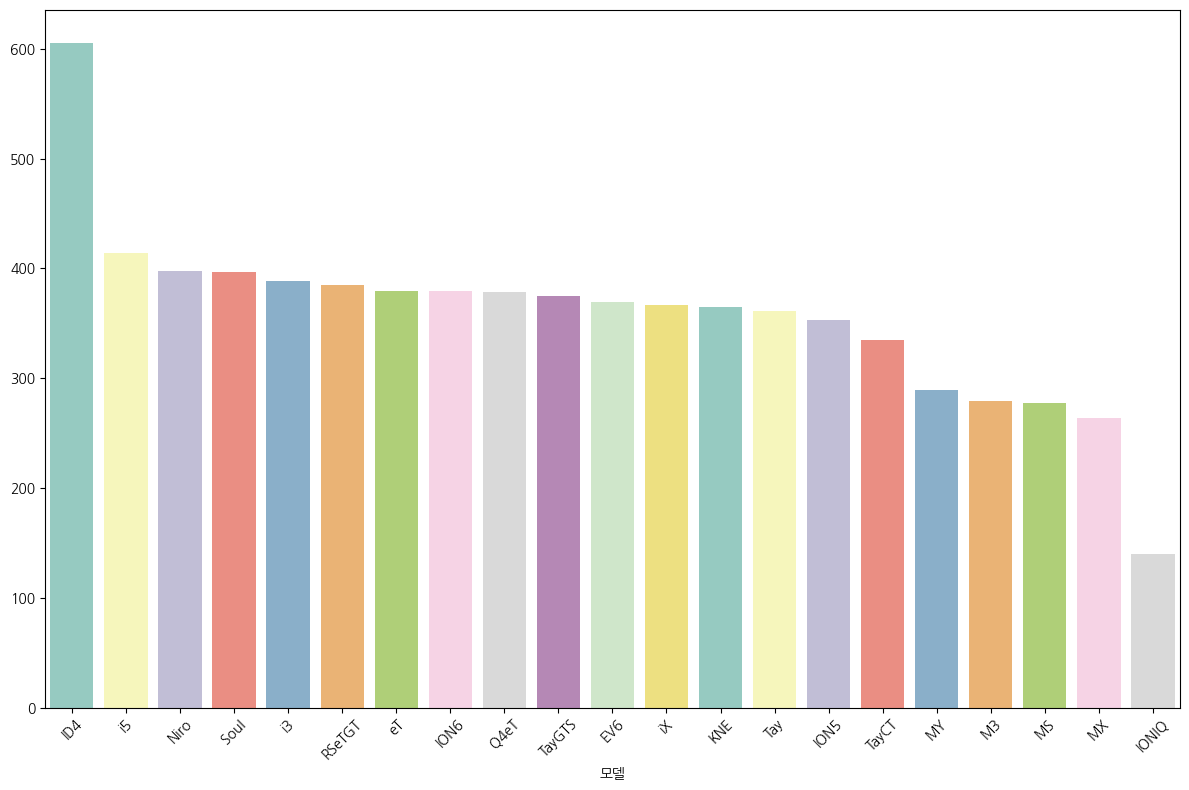

In [7]:
show_graph('모델')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


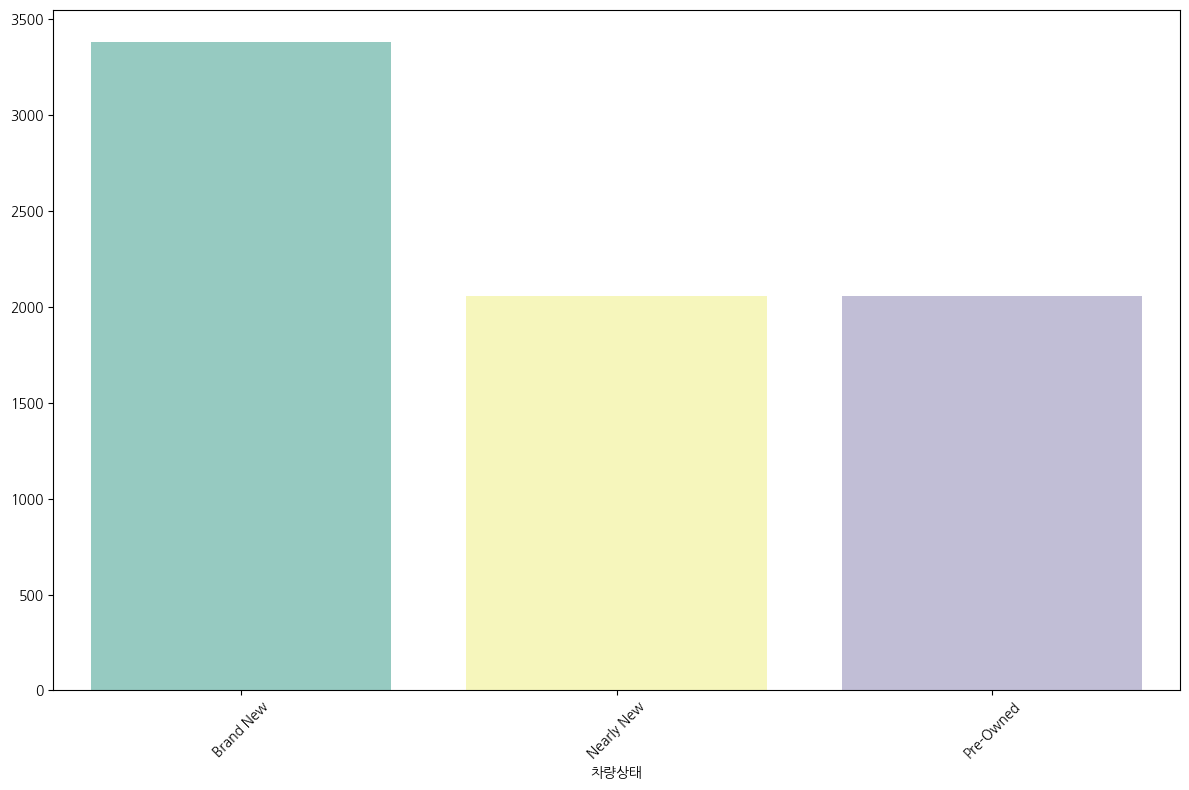

In [8]:
show_graph('차량상태')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


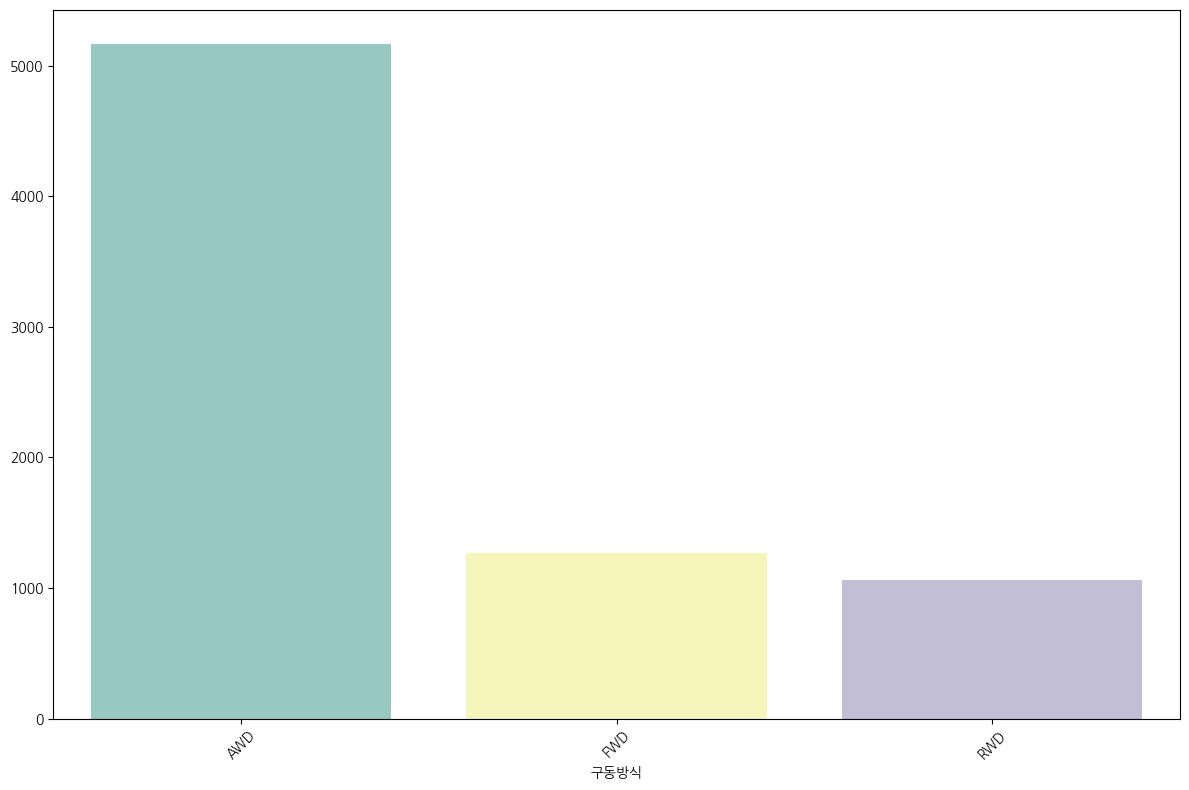

In [9]:
show_graph('구동방식')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\4183445985.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df[f'{col}'].value_counts().index,


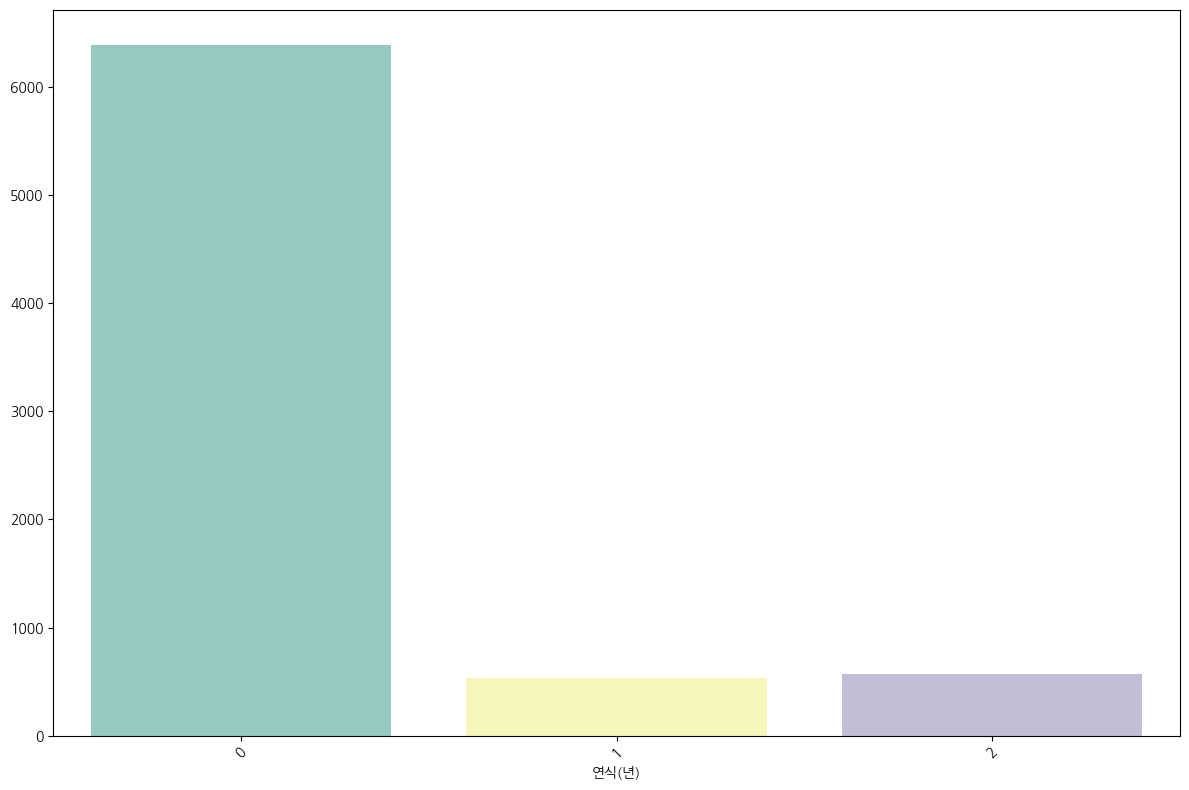

In [10]:
show_graph('연식(년)')

In [11]:
def print_mean_battery(col):
    for i in train_df[col].unique():
        print(f"{col} - {i} : {train_df[train_df[col] == i]['배터리용량'].mean()}")

In [12]:
print_mean_battery('연식(년)')

연식(년) - 2 : 69.538296
연식(년) - 0 : 69.68484126984127
연식(년) - 1 : 66.74253498871332


In [13]:
print_mean_battery('모델')

모델 - TayGTS : 80.45416988416989
모델 - Niro : 54.578933333333325
모델 - eT : 83.77656402439024
모델 - RSeTGT : 84.39925242718446
모델 - i5 : 65.49336119402984
모델 - ION6 : 65.87692340425532
모델 - MS : 89.67221266968326
모델 - MY : 63.91637988826815
모델 - Q4eT : 69.0407149122807
모델 - ID4 : 65.42444
모델 - TayCT : 77.5639326923077
모델 - Soul : 53.71446036585366
모델 - iX : 90.0
모델 - MX : 90.03115121951218
모델 - IONIQ : 62.04435185185184
모델 - EV6 : 90.0
모델 - KNE : 72.11759670781893
모델 - M3 : 64.48288165680474
모델 - i3 : 52.691131498470945
모델 - ION5 : 66.43954545454545
모델 - Tay : 67.16731555555556


In [14]:
print_mean_battery('보증기간(년)')

보증기간(년) - 0 : 59.936046931407944
보증기간(년) - 6 : 68.75179527559055
보증기간(년) - 7 : 83.86369625246549
보증기간(년) - 3 : 61.30074884792627
보증기간(년) - 1 : 59.83024901185771
보증기간(년) - 5 : 64.60444846796658
보증기간(년) - 8 : 84.68549800796812
보증기간(년) - 10 : 90.0
보증기간(년) - 2 : 68.24809410548086
보증기간(년) - 4 : 61.65939722222222
보증기간(년) - 9 : 90.0


In [15]:
print_mean_battery('차량상태')

차량상태 - Nearly New : 66.67888807649044
차량상태 - Brand New : 92.5865671641791
차량상태 - Pre-Owned : 59.053240185950415


In [16]:
print_mean_battery('제조사')

제조사 - P사 : 75.26528034682082
제조사 - K사 : 57.49066711590296
제조사 - A사 : 78.77559787556905
제조사 - B사 : 62.34454742547425
제조사 - H사 : 67.39844044665013
제조사 - T사 : 78.31083204134367
제조사 - V사 : 65.42444


In [17]:
train_df.groupby('연식(년)')['배터리용량'].mean()

연식(년)
0    69.684841
1    66.742535
2    69.538296
Name: 배터리용량, dtype: float64

In [18]:
train_df.groupby('모델')['배터리용량'].describe()

,count,mean,std,min,25%,50%,75%,max
모델,,,,,,,,
EV6,69.0,90.000000,0.000000,90.000,90.000,90.000,90.000,90.00
ID4,375.0,65.424440,10.603580,53.325,57.861,62.784,68.125,90.00
ION5,220.0,66.439545,11.940341,53.602,58.162,63.110,71.332,90.00
ION6,235.0,65.876923,11.407106,53.602,58.162,63.110,68.479,90.00
IONIQ,108.0,62.044352,10.958746,46.090,52.745,60.875,68.725,88.08
KNE,243.0,72.117597,8.073049,68.488,68.488,68.488,68.488,90.00
M3,169.0,64.482882,11.828421,51.940,56.359,61.153,66.355,90.00
MS,221.0,89.672213,10.961315,69.253,78.276,96.000,99.800,99.80
MX,205.0,90.031151,11.367376,69.253,75.145,96.000,99.800,99.80


In [19]:
train_df[(train_df['차량상태'] == 'Pre-Owned')]['주행거리(km)'].describe()

count      2058.000000
mean     122610.892128
std       45517.411096
min       11477.000000
25%       82717.000000
50%      123352.500000
75%      161763.500000
max      199827.000000
Name: 주행거리(km), dtype: float64

In [20]:
train_df[(train_df['주행거리(km)'] >= 70000) & ~(train_df['차량상태'] == 'Pre-Owned')]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
62,TRAIN_0062,H사,IONIQ,Nearly New,75.87,FWD,70822,3,No,0,11.12
143,TRAIN_0143,H사,IONIQ,Nearly New,58.77,FWD,73469,3,No,0,24.04
271,TRAIN_0271,H사,IONIQ,Nearly New,58.35,FWD,70295,3,No,2,17.77
1223,TRAIN_1223,H사,IONIQ,Nearly New,NaN,FWD,73315,3,No,2,19.36
1304,TRAIN_1304,H사,IONIQ,Nearly New,86.68,FWD,76186,3,No,0,18.64
1326,TRAIN_1326,H사,IONIQ,Nearly New,46.42,FWD,74210,3,No,2,22.50
1422,TRAIN_1422,H사,IONIQ,Nearly New,52.75,FWD,77376,3,No,2,18.45
2141,TRAIN_2141,H사,IONIQ,Nearly New,NaN,FWD,70021,3,No,0,12.16
2573,TRAIN_2573,H사,IONIQ,Nearly New,52.18,FWD,76024,3,No,1,12.12
2599,TRAIN_2599,H사,IONIQ,Nearly New,85.96,FWD,72248,3,No,1,20.71


In [21]:
train_df[(train_df['주행거리(km)'] <= 10000) & (train_df['차량상태'] == 'Nearly New')]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)


In [22]:
train_df['주행거리'] = train_df['주행거리(km)'].apply(lambda x: 'new' if x <= 10000 else ('mid' if x <= 80000 else 'old'))
test_df['주행거리'] = test_df['주행거리(km)'].apply(lambda x: 'new' if x <= 10000 else ('mid' if x <= 80000 else 'old'))

In [23]:
test_df[(test_df['모델'] == 'EV6') & (test_df['보증기간(년)'] <= 8)]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),주행거리


In [24]:
def draw_mean_battery(col):
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.barplot(x = sorted(train_df[col].unique()),
                y = train_df.groupby(col)['배터리용량'].mean(),
                palette = 'tab20c',
                ax = ax)
    plt.xticks(rotation = 45, size = 20)
    plt.yticks(size = 15)
    plt.title(f'{col} - 평균 배터리', size = 20)
    ax.set_ylabel('배터리 용량 (평균)', fontsize = 20)
    plt.tight_layout()
    plt.show()

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


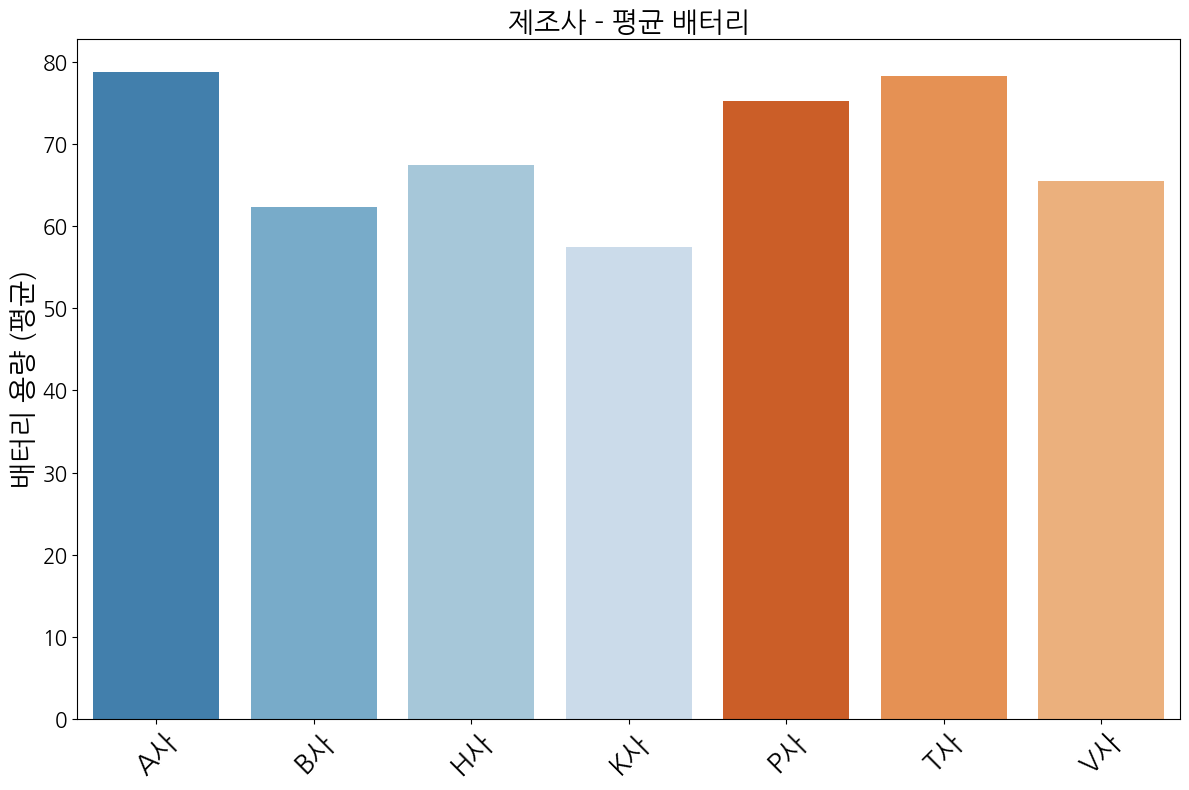

In [25]:
draw_mean_battery('제조사')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


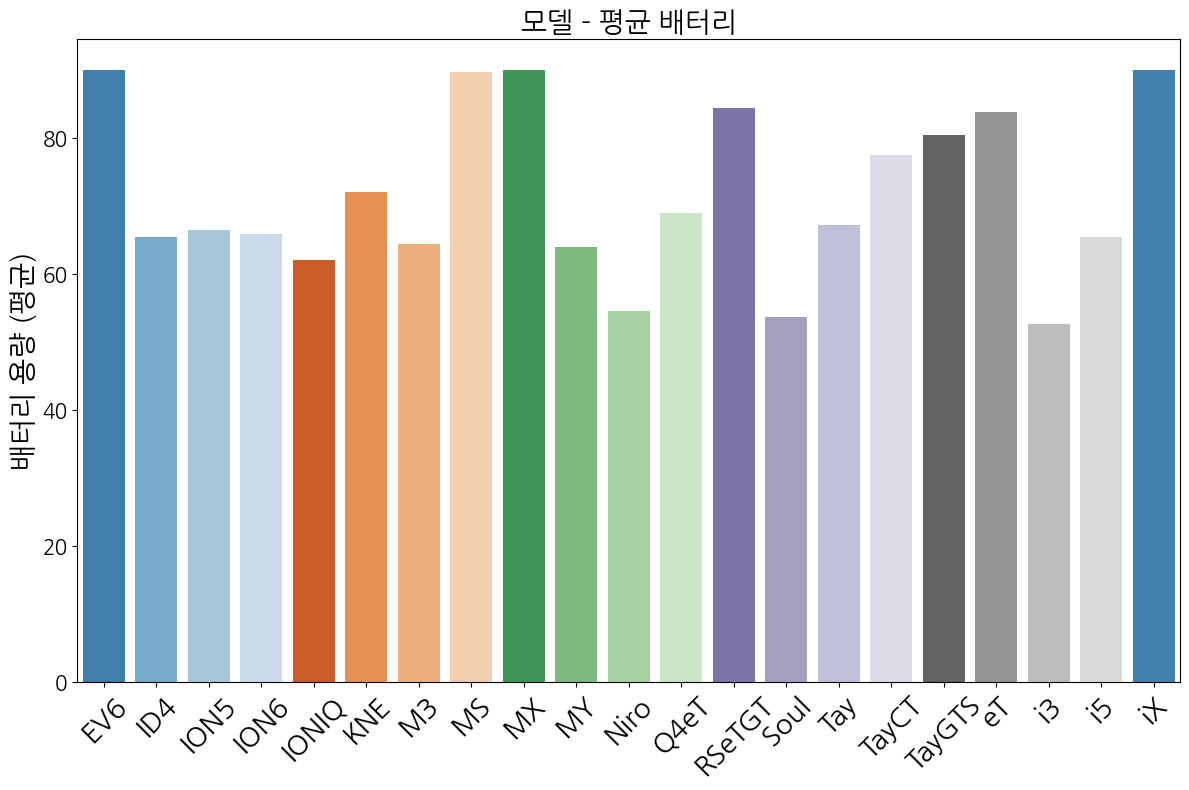

In [26]:
draw_mean_battery('모델')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


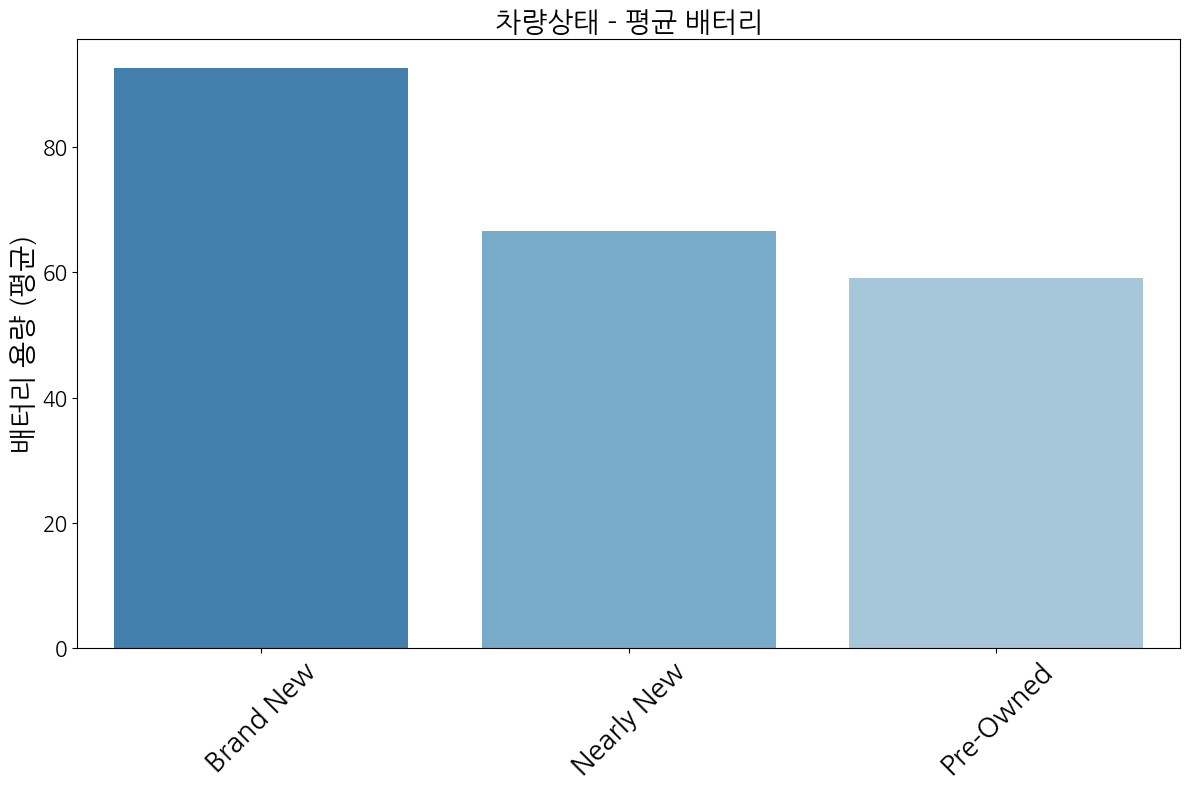

In [27]:
draw_mean_battery('차량상태')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\834823150.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


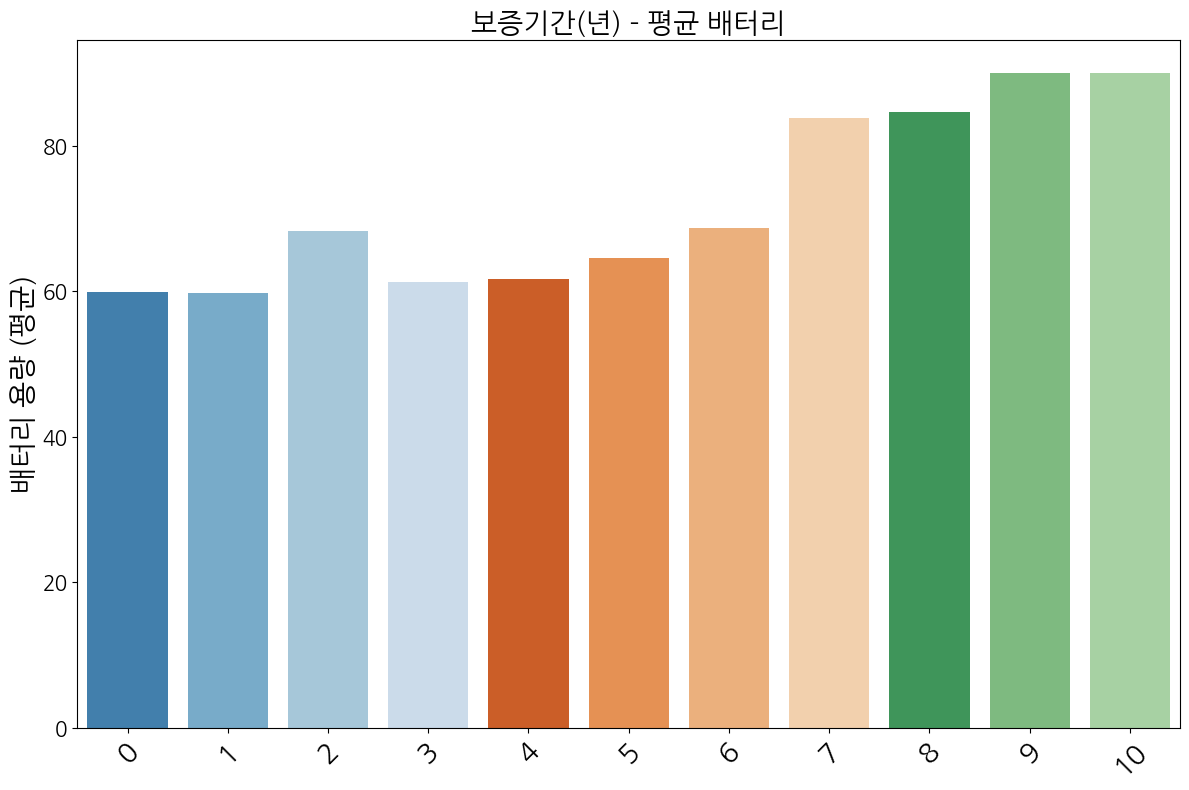

In [28]:
draw_mean_battery('보증기간(년)')

In [29]:
train_df.corr(numeric_only = True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


모델, 보증기간 7년 이상, 차량 상태가 배터리 용량을 결정

In [30]:
train_df[(train_df['차량상태'] == 'Brand New') & ~(train_df['배터리용량'].isna())]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리
2,TRAIN_0002,A사,eT,Brand New,91.2,AWD,2361,7,No,0,66.27,new
15,TRAIN_0015,A사,eT,Brand New,91.2,AWD,5681,7,No,0,66.12,new
20,TRAIN_0020,T사,MS,Brand New,99.8,AWD,1405,8,No,0,63.90,new
49,TRAIN_0049,T사,MX,Brand New,96.0,AWD,7626,7,No,0,77.32,new
54,TRAIN_0054,T사,MS,Brand New,96.0,AWD,6658,7,No,0,70.22,new
...,...,...,...,...,...,...,...,...,...,...,...,...
7444,TRAIN_7444,B사,i5,Brand New,90.0,AWD,2720,8,No,0,64.93,new
7465,TRAIN_7465,P사,Tay,Brand New,90.0,AWD,2765,2,No,0,104.25,new
7472,TRAIN_7472,T사,MS,Brand New,99.8,AWD,83,8,No,0,63.37,new
7475,TRAIN_7475,K사,EV6,Brand New,90.0,AWD,3009,9,No,0,41.99,new


In [31]:
train_df[train_df['배터리용량'].isna()]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16,mid
6,TRAIN_0006,T사,MS,Nearly New,NaN,AWD,19395,3,No,0,83.42,mid
8,TRAIN_0008,T사,MY,Brand New,NaN,AWD,2226,8,No,0,74.06,new
9,TRAIN_0009,A사,Q4eT,Brand New,NaN,AWD,3683,7,No,0,59.66,new
11,TRAIN_0011,V사,ID4,Brand New,NaN,AWD,1131,8,No,0,40.50,new
...,...,...,...,...,...,...,...,...,...,...,...,...
7489,TRAIN_7489,H사,ION5,Brand New,NaN,AWD,8871,9,No,0,35.83,new
7490,TRAIN_7490,A사,Q4eT,Brand New,NaN,AWD,5794,7,No,0,59.95,new
7491,TRAIN_7491,K사,Soul,Brand New,NaN,FWD,5966,10,No,0,16.75,new
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95,new


In [32]:
train_df['보증기간'] = train_df['보증기간(년)'].apply(lambda x: 'high' if x >= 7 else 'low')
test_df['보증기간'] = test_df['보증기간(년)'].apply(lambda x: 'high' if x >= 7 else 'low')

In [33]:
def fill_battery(cond_df, df):
    for i in range(len(cond_df)):
        model = cond_df.iloc[i]['모델']
        status = cond_df.iloc[i]['차량상태']
        warranty = cond_df.iloc[i]['보증기간']
        
        cond = (train_df['모델'] == model) & (train_df['차량상태'] == status) & (train_df['보증기간'] == warranty)       
        df.loc[cond_df.iloc[i].name, '배터리용량'] = train_df[cond]['배터리용량'].mean()

In [34]:
fill_battery(train_df[train_df['배터리용량'].isna()], train_df)
fill_battery(test_df[test_df['배터리용량'].isna()], test_df)

In [35]:
train_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,mid,low
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,mid,low
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,new,high
3,TRAIN_0003,A사,RSeTGT,Nearly New,78.227,AWD,21683,3,No,0,99.16,mid,low
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,old,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,90.000,AWD,3773,10,No,0,35.95,new,high
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40,old,low
7494,TRAIN_7494,P사,TayCT,Brand New,90.000,AWD,1363,2,No,0,120.00,new,low
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00,mid,low


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     7497 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
 11  주행거리      7497 non-null   object 
 12  보증기간      7497 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 761.5+ KB


In [37]:
test_df

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),주행거리,보증기간
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0,mid,low
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0,new,high
2,TEST_002,B사,i5,Brand New,90.000,RWD,7197,7,Yes,0,new,high
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1,mid,high
4,TEST_004,K사,EV6,Brand New,90.000,FWD,7597,10,No,0,new,high
...,...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0,old,low
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0,mid,low
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0,old,low
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0,mid,low


In [38]:
def draw_mean_price(col):
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.barplot(x = sorted(train_df[col].unique()),
                y = train_df.groupby(col)['가격(백만원)'].mean(),
                palette = 'tab20c',
                ax = ax)
    plt.xticks(rotation = 45, size = 20)
    plt.yticks(size = 15)
    plt.title(f'{col} - 평균 가격', size = 20)
    ax.set_ylabel('가격 (평균)', fontsize = 20)
    plt.tight_layout()
    plt.show()

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


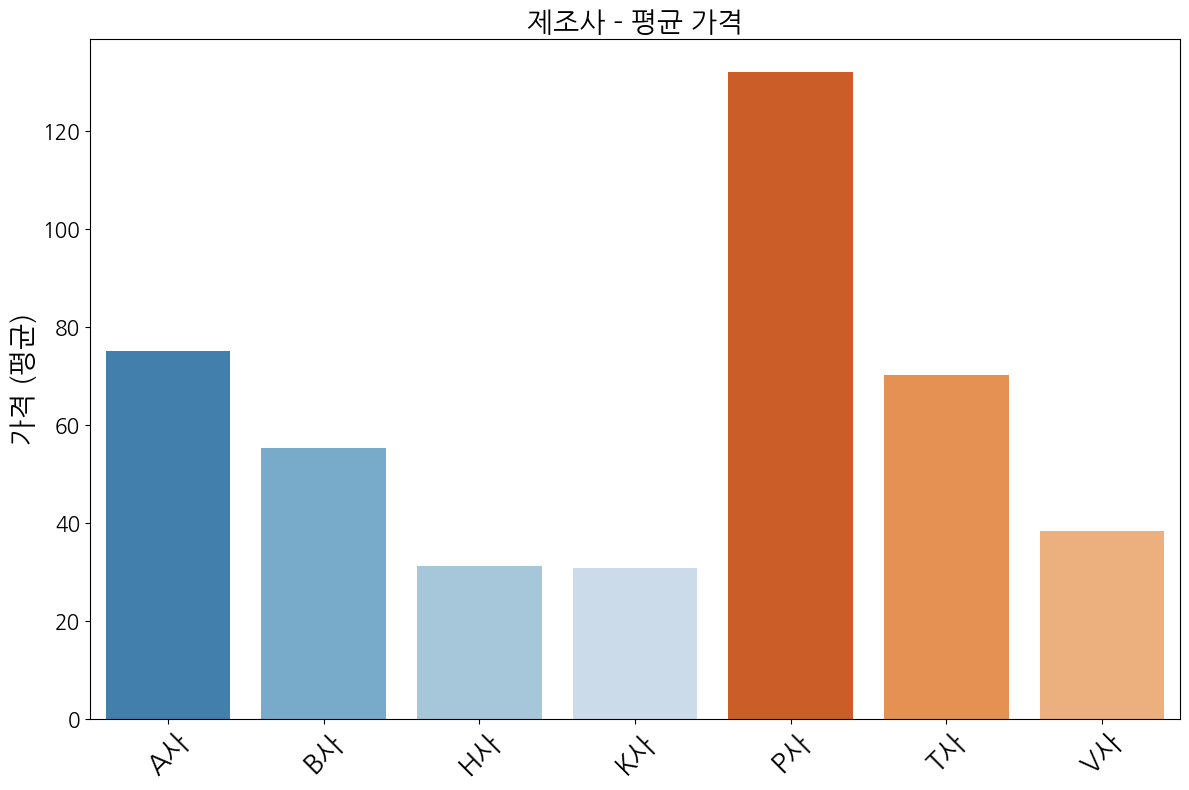

In [39]:
draw_mean_price('제조사')

In [40]:
train_df[train_df['제조사'] == 'K사']

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,mid,low
10,TRAIN_0010,K사,Niro,Nearly New,58.982,FWD,10879,8,No,2,28.78,mid,high
13,TRAIN_0013,K사,Niro,Brand New,90.000,AWD,1191,10,Yes,0,21.36,new,high
14,TRAIN_0014,K사,Niro,Nearly New,56.000,FWD,16011,5,No,0,28.87,mid,low
17,TRAIN_0017,K사,Soul,Nearly New,56.000,AWD,28687,6,Yes,0,22.77,mid,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475,TRAIN_7475,K사,EV6,Brand New,90.000,AWD,3009,9,No,0,41.99,new,high
7478,TRAIN_7478,K사,Soul,Pre-Owned,46.000,FWD,72498,1,No,0,22.38,mid,low
7480,TRAIN_7480,K사,EV6,Brand New,90.000,FWD,4067,9,No,0,41.55,new,high
7482,TRAIN_7482,K사,Soul,Brand New,90.000,AWD,8287,10,No,0,17.41,new,high


C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


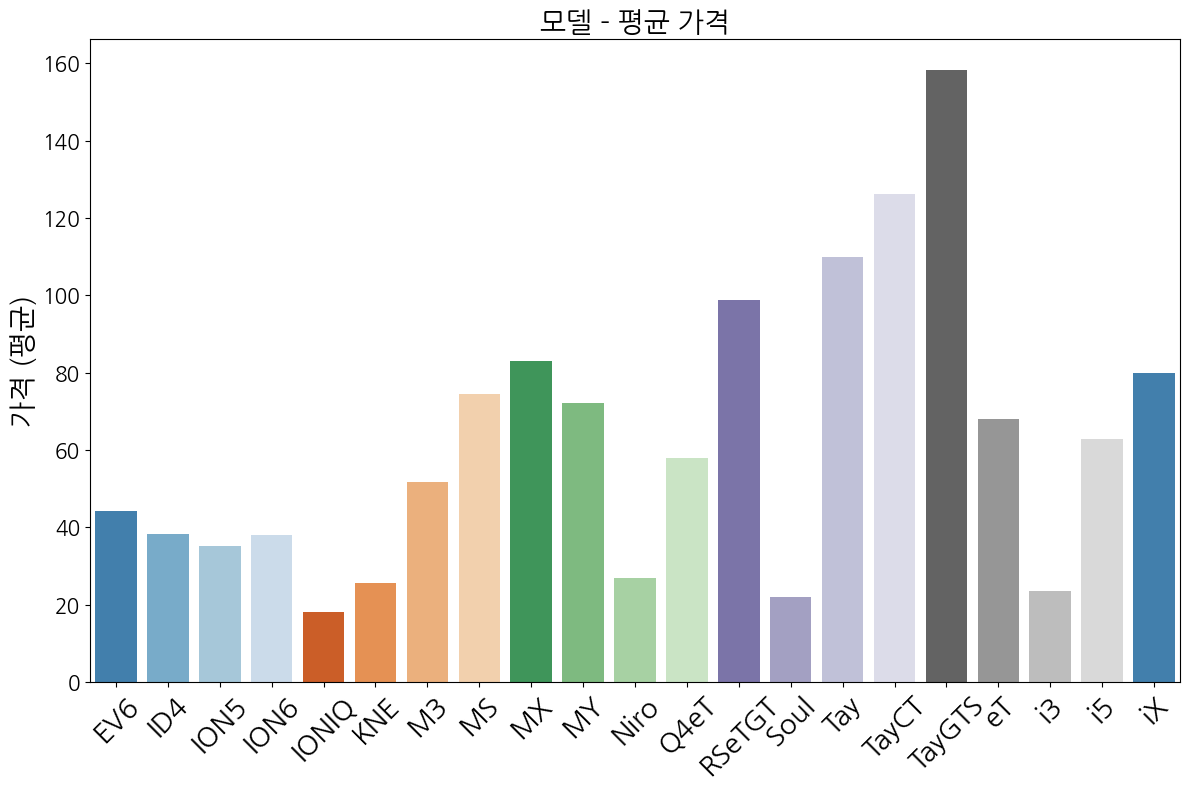

In [41]:
draw_mean_price('모델')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


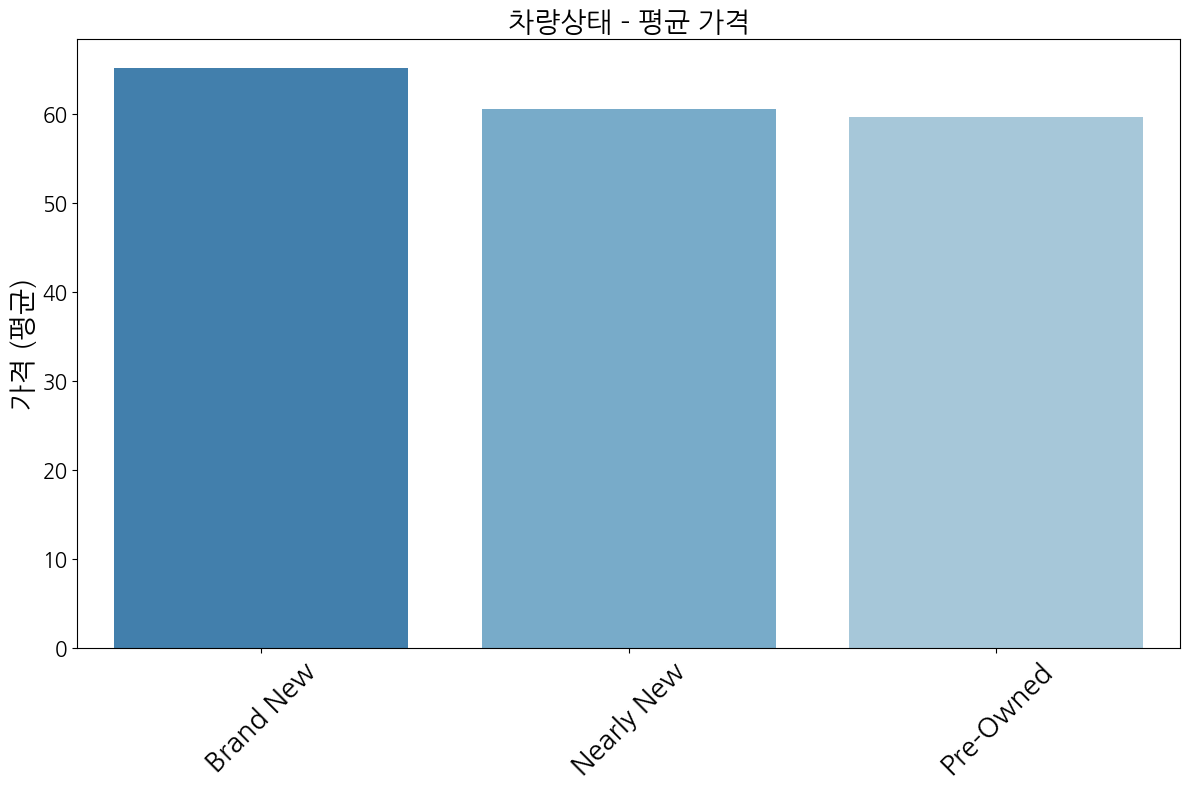

In [42]:
draw_mean_price('차량상태')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


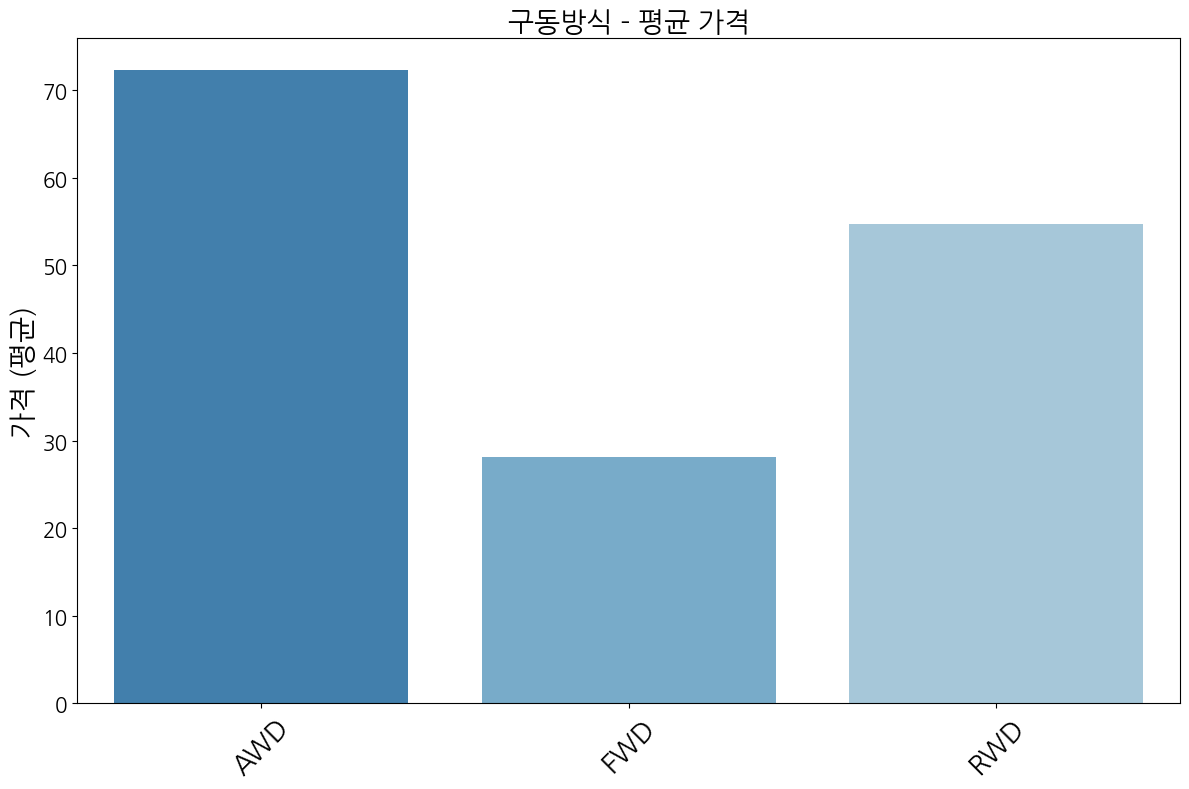

In [43]:
draw_mean_price('구동방식')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


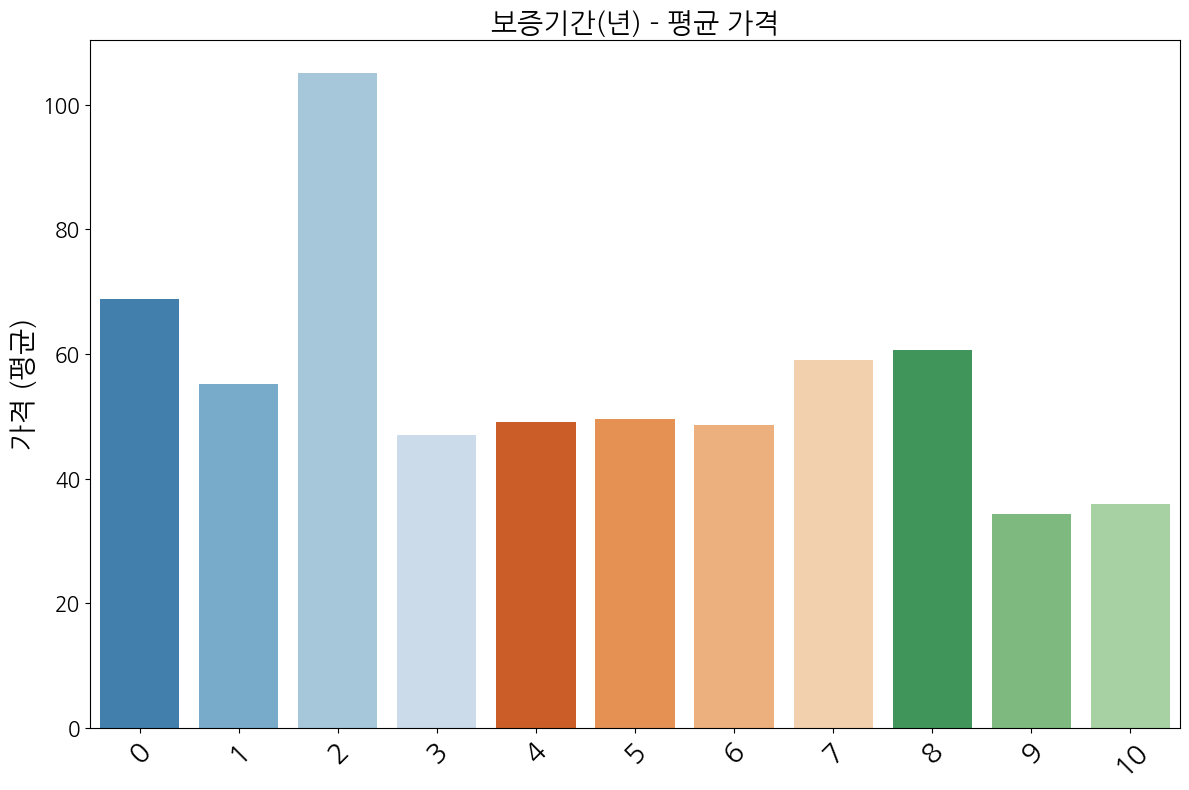

In [44]:
draw_mean_price('보증기간(년)')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


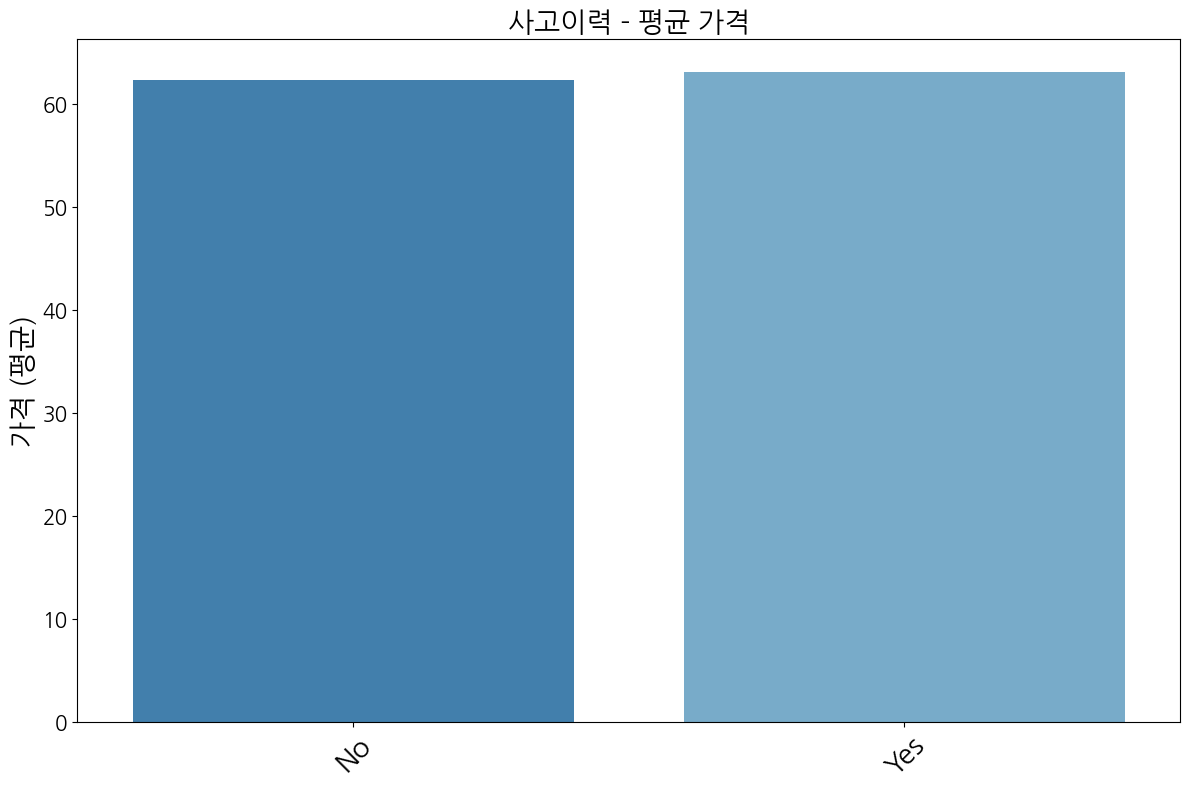

In [45]:
draw_mean_price('사고이력')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


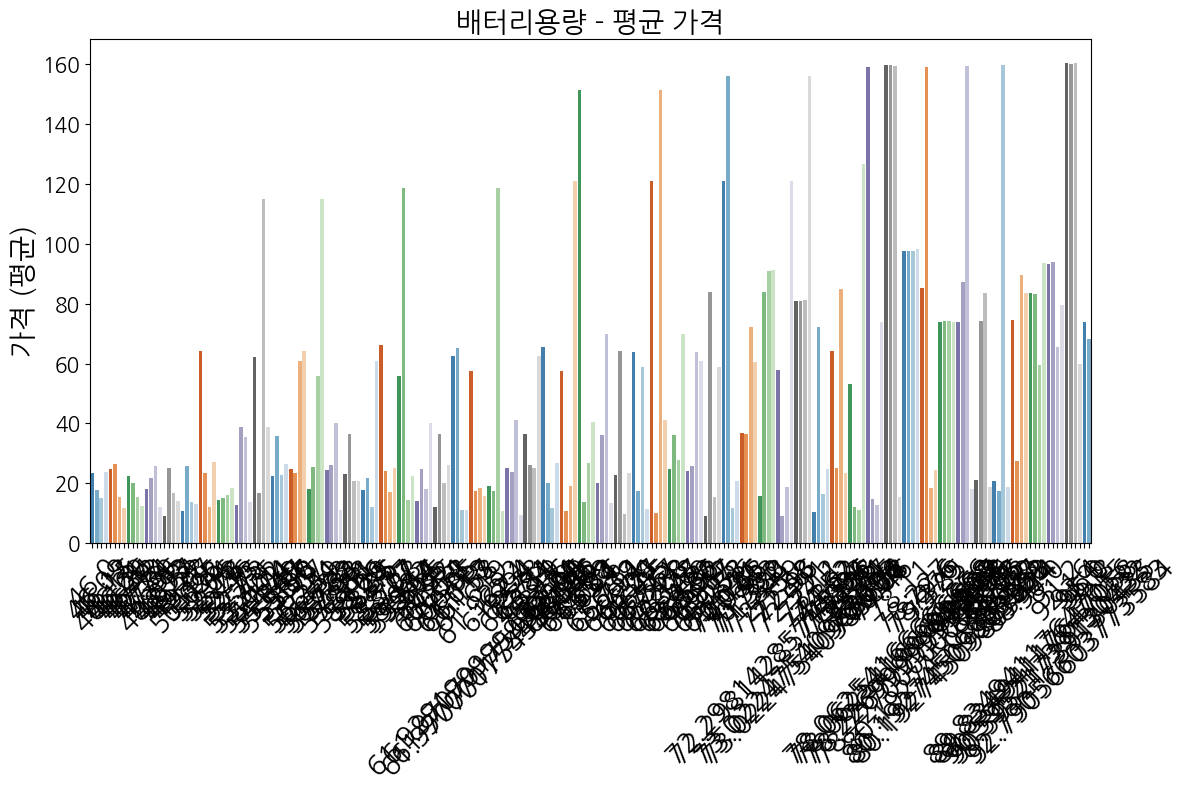

In [46]:
draw_mean_price('배터리용량')

C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


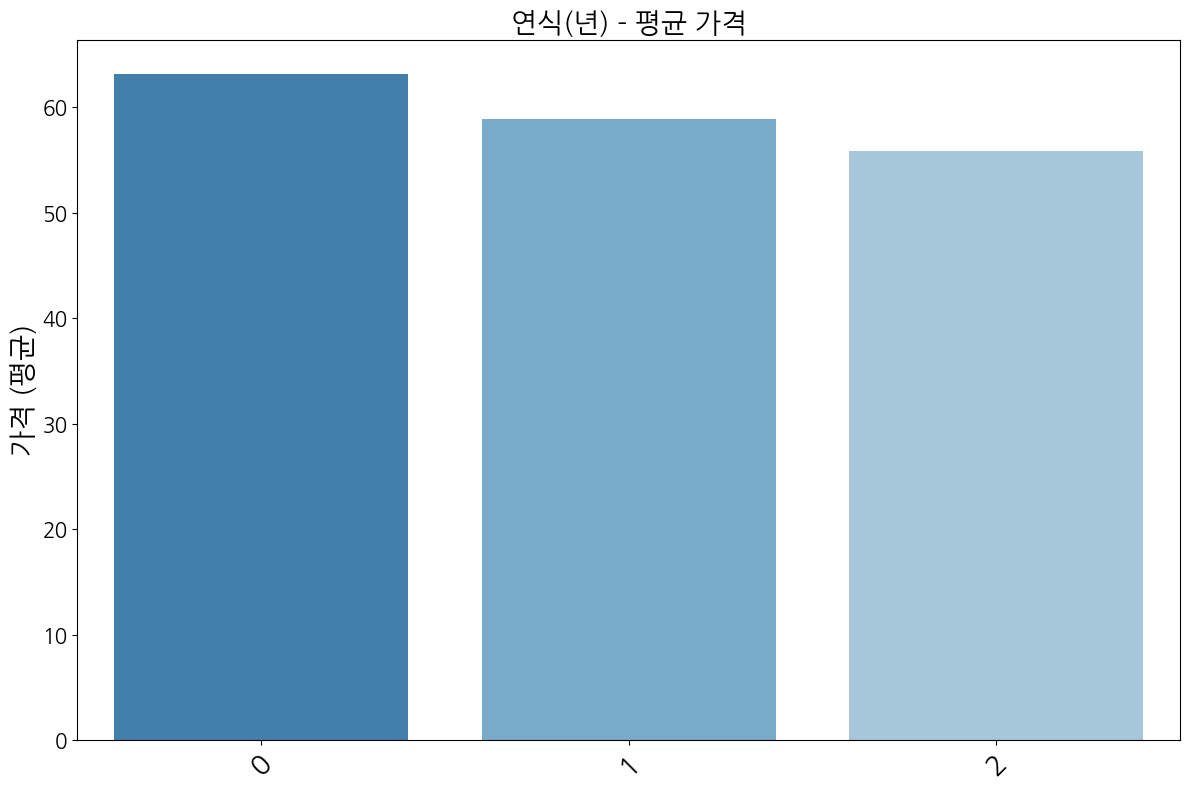

In [47]:
draw_mean_price('연식(년)')

In [48]:
mean_prices = train_df.groupby('모델')['가격(백만원)'].mean()
train_df['모델_평균가격순위'] = train_df['모델'].map(mean_prices.rank(ascending = False))
test_df['모델_평균가격순위'] = test_df['모델'].map(mean_prices.rank(ascending = False))  # train 데이터 기반으로 rank 적용


In [49]:
mean_prices = train_df.groupby('제조사')['가격(백만원)'].mean()
train_df['제조사_평균가격순위'] = train_df['제조사'].map(mean_prices.rank(ascending = False))
test_df['제조사_평균가격순위'] = test_df['제조사'].map(mean_prices.rank(ascending = False))  # train 데이터 기반으로 rank 적용


In [50]:
object_list = ['제조사', '모델', '차량상태', '구동방식', '보증기간', '사고이력', '주행거리']


for col in object_list:
    encoder = LabelEncoder()
    encoder.fit(train_df[col])
    train_df[col] = encoder.transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])
    


In [51]:
train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위
0,TRAIN_0000,4,16,1,86.077,0,13642,0,0,2,159.66,0,1,1.0,1.0
1,TRAIN_0001,3,10,1,56.000,1,10199,6,0,0,28.01,0,1,17.0,7.0
2,TRAIN_0002,0,17,0,91.200,0,2361,7,0,0,66.27,1,0,9.0,2.0
3,TRAIN_0003,0,12,1,78.227,0,21683,3,0,0,99.16,0,1,4.0,2.0
4,TRAIN_0004,1,19,2,61.018,0,178205,1,0,0,62.02,2,1,10.0,4.0


In [52]:
test_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위
0,TEST_000,4,15,1,76.093,0,14057,2,0,0,0,1,2.0,1.0
1,TEST_001,1,20,0,90.000,0,7547,8,0,0,1,0,6.0,4.0
2,TEST_002,1,19,0,90.000,2,7197,7,1,0,1,0,10.0,4.0
3,TEST_003,2,2,1,68.479,0,10357,7,0,1,0,0,16.0,6.0
4,TEST_004,3,0,0,90.000,1,7597,10,0,0,1,0,13.0,7.0


C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\816830177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(train_df[col].unique()),


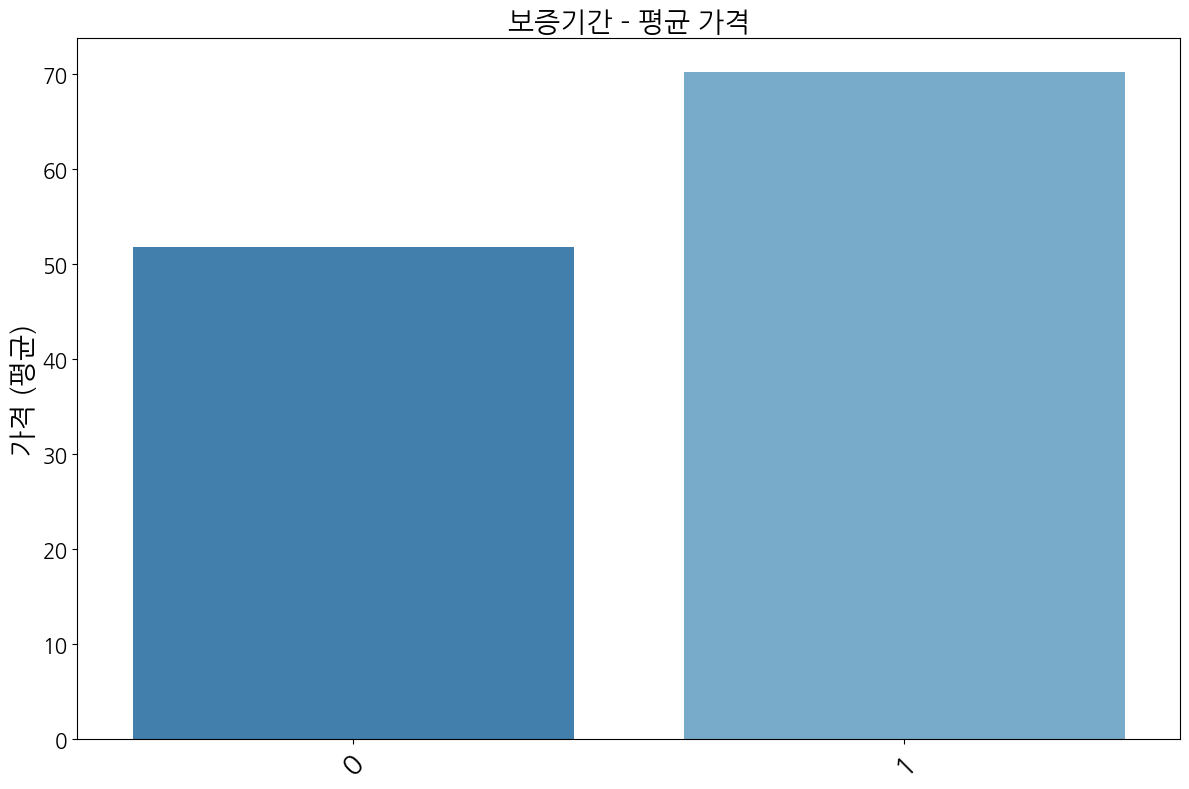

In [53]:
draw_mean_price('보증기간')

In [54]:
train_df[(train_df['제조사'] == 0) & (train_df['차량상태'] == 0)]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위
2,TRAIN_0002,0,17,0,91.2,0,2361,7,0,0,66.27,1,0,9.0,2.0
9,TRAIN_0009,0,11,0,90.0,0,3683,7,0,0,59.66,1,0,11.0,2.0
15,TRAIN_0015,0,17,0,91.2,0,5681,7,0,0,66.12,1,0,9.0,2.0
45,TRAIN_0045,0,12,0,90.0,0,975,7,0,0,100.38,1,0,4.0,2.0
59,TRAIN_0059,0,12,0,90.0,0,1461,8,0,0,100.17,1,0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7458,TRAIN_7458,0,12,0,90.0,0,8342,8,0,0,101.01,1,0,4.0,2.0
7460,TRAIN_7460,0,12,0,90.0,0,6306,8,0,0,100.01,1,0,4.0,2.0
7462,TRAIN_7462,0,11,0,90.0,0,4578,8,0,0,59.97,1,0,11.0,2.0
7486,TRAIN_7486,0,17,0,91.2,0,602,7,0,0,65.57,1,0,9.0,2.0


In [55]:
train_df[(train_df['제조사'] == 0) & (train_df['차량상태'] == 1)]

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위
3,TRAIN_0003,0,12,1,78.227000,0,21683,3,0,0,99.16,0,1,4.0,2.0
7,TRAIN_0007,0,12,1,78.227000,0,30583,5,0,1,99.66,0,1,4.0,2.0
41,TRAIN_0041,0,11,1,72.548000,0,38960,5,0,1,57.27,0,1,11.0,2.0
65,TRAIN_0065,0,17,1,77.460000,0,17020,3,0,0,74.00,0,1,9.0,2.0
82,TRAIN_0082,0,17,1,77.460000,0,15126,3,0,0,73.26,0,1,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,TRAIN_7274,0,11,1,66.861000,0,45458,3,0,0,58.98,0,1,11.0,2.0
7356,TRAIN_7356,0,12,1,78.227000,0,12935,4,0,0,99.12,0,1,4.0,2.0
7374,TRAIN_7374,0,17,1,80.192745,0,38212,6,1,2,73.87,0,1,9.0,2.0
7392,TRAIN_7392,0,12,1,78.227000,0,17393,3,0,0,99.00,0,1,4.0,2.0


In [56]:
train_df.drop(['ID'], axis = 1, inplace = True)
test_df.drop(['ID'], axis = 1, inplace = True)

In [57]:
train_df['모델'].value_counts()

모델
1     605
19    414
10    398
13    397
18    388
12    385
17    379
3     379
11    378
16    375
0     369
20    367
5     365
14    361
2     353
15    335
9     289
6     279
7     277
8     264
4     140
Name: count, dtype: int64

In [58]:
train_df['모델'].unique()

array([16, 10, 17, 12, 19,  3,  7,  9, 11,  1, 15, 13, 20,  8,  4,  0,  5,
        6, 18,  2, 14])

In [59]:
train_df['연식_대비_배터리'] = train_df['배터리용량'] / (2025 - train_df['연식(년)'])
test_df['연식_대비_배터리'] = test_df['배터리용량'] / (2025 - test_df['연식(년)'])


In [60]:
train_df['연식_대비_보증기간'] = (2025 + train_df['보증기간(년)']) / (2025 - train_df['연식(년)'])
test_df['연식_대비_보증기간'] = (2025 + test_df['보증기간(년)']) / (2025 - test_df['연식(년)'])


In [61]:
np.random.seed(7)
random.seed(7)

def oversampling(train_df):
    columns = train_df['모델'].unique()
    
    for col in columns:
        for j in range(int(train_df['모델'].value_counts()[col] * 0.3)):
            new_row = train_df[train_df['모델'] == col].sample(1, replace = True).copy()
            new_row['배터리용량'] += np.random.normal(0, 0.1)
            new_row['가격(백만원)'] += np.random.normal(0, 0.01)
            train_df = pd.concat([train_df, new_row], ignore_index = True)

    return train_df

train_df = oversampling(train_df)

train_df

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),주행거리,보증기간,모델_평균가격순위,제조사_평균가격순위,연식_대비_배터리,연식_대비_보증기간
0,4,16,1,86.077000,0,13642,0,0,2,159.660000,0,1,1.0,1.0,0.042549,1.000989
1,3,10,1,56.000000,1,10199,6,0,0,28.010000,0,1,17.0,7.0,0.027654,1.002963
2,0,17,0,91.200000,0,2361,7,0,0,66.270000,1,0,9.0,2.0,0.045037,1.003457
3,0,12,1,78.227000,0,21683,3,0,0,99.160000,0,1,4.0,2.0,0.038631,1.001481
4,1,19,2,61.018000,0,178205,1,0,0,62.020000,2,1,10.0,4.0,0.030132,1.000494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,4,14,0,90.091129,0,512,2,0,0,95.764886,1,1,3.0,1.0,0.044444,1.000988
9733,4,14,2,59.702549,0,133697,2,0,0,118.815669,2,1,3.0,1.0,0.029390,1.000988
9734,4,14,0,90.123357,0,1306,2,0,0,104.626506,1,1,3.0,1.0,0.044444,1.000988
9735,4,14,0,90.020399,0,599,2,0,0,104.790332,1,1,3.0,1.0,0.044444,1.000988


In [62]:
train_df['모델'].value_counts()

모델
1     786
19    538
10    517
13    516
18    504
12    500
17    492
3     492
11    491
16    487
0     479
20    477
5     474
14    469
2     458
15    435
9     375
6     362
7     360
8     343
4     182
Name: count, dtype: int64

In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9737 entries, 0 to 9736
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   제조사         9737 non-null   int32  
 1   모델          9737 non-null   int32  
 2   차량상태        9737 non-null   int32  
 3   배터리용량       9737 non-null   float64
 4   구동방식        9737 non-null   int32  
 5   주행거리(km)    9737 non-null   int64  
 6   보증기간(년)     9737 non-null   int64  
 7   사고이력        9737 non-null   int32  
 8   연식(년)       9737 non-null   int64  
 9   가격(백만원)     9737 non-null   float64
 10  주행거리        9737 non-null   int32  
 11  보증기간        9737 non-null   int32  
 12  모델_평균가격순위   9737 non-null   float64
 13  제조사_평균가격순위  9737 non-null   float64
 14  연식_대비_배터리   9737 non-null   float64
 15  연식_대비_보증기간  9737 non-null   float64
dtypes: float64(6), int32(7), int64(3)
memory usage: 951.0 KB


In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   제조사         846 non-null    int32  
 1   모델          846 non-null    int32  
 2   차량상태        846 non-null    int32  
 3   배터리용량       846 non-null    float64
 4   구동방식        846 non-null    int32  
 5   주행거리(km)    846 non-null    int64  
 6   보증기간(년)     846 non-null    int64  
 7   사고이력        846 non-null    int32  
 8   연식(년)       846 non-null    int64  
 9   주행거리        846 non-null    int32  
 10  보증기간        846 non-null    int32  
 11  모델_평균가격순위   846 non-null    float64
 12  제조사_평균가격순위  846 non-null    float64
 13  연식_대비_배터리   846 non-null    float64
 14  연식_대비_보증기간  846 non-null    float64
dtypes: float64(5), int32(7), int64(3)
memory usage: 76.1 KB


In [65]:
target = train_df[['가격(백만원)']]
feature = train_df.drop(['가격(백만원)', '주행거리(km)'], axis = 1)

target

,가격(백만원)
0,159.660000
1,28.010000
2,66.270000
3,99.160000
4,62.020000
...,...
9732,95.764886
9733,118.815669
9734,104.626506
9735,104.790332


In [66]:
test_df = test_df.drop(['주행거리(km)'], axis = 1)

In [67]:
df1 = pd.DataFrame(feature)
df2 = pd.DataFrame(test_df)

for col in df1.columns:
    stscaler = StandardScaler()
    stscaler.fit(df1[[col]])
    df1[col] = stscaler.transform(df1[[col]])
    df2[col] = stscaler.transform(df2[[col]])

In [68]:
kmeans = KMeans(n_clusters = 5, random_state = 7)
kmeans.fit(df1)

feature['cluster'] = kmeans.predict(df1)
test_df['cluster'] = kmeans.predict(df2)

In [69]:
def xgb_objective(trial):
    param = {
        'objective': 'reg:squarederror',
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.00001, 1, log=True),
        'eval_metric': 'rmse',
        "n_jobs": -1
    }

    # XGBRegressor 모델 생성
    xgb_model = xgb.XGBRegressor(**param)

    # 교차 검증
    scores = cross_val_score(xgb_model, feature, target, cv=10, scoring="neg_mean_squared_error")

    # RMSE 계산
    rmse = (-scores.mean()) ** 0.5

    return rmse

In [70]:
optuna.logging.set_verbosity(optuna.logging.WARNING)


xgb_study = optuna.create_study(direction = "minimize")
xgb_study.optimize(xgb_objective, n_trials = 1000, show_progress_bar = True)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters:", xgb_study.best_params)

# 최적 하이퍼파라미터로 최종 모델 학습
xgb_best_param = xgb_study.best_params


Best trial: 954. Best value: 1.26677: 100%|██████████| 1000/1000 [2:48:29<00:00, 10.11s/it] 

Best hyperparameters: {'n_estimators': 692, 'colsample_bytree': 0.7713497577216677, 'subsample': 0.959704458706269, 'learning_rate': 0.01033262662319791, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.6710705671360453}


In [71]:
xgb_final_model = xgb.XGBRegressor(**xgb_best_param, random_state = 7)

xgb_final_model.fit(feature, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7713497577216677, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.6710705671360453,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01033262662319791,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=692, n_jobs=None,
             num_parallel_tree=None, random_state=7, ...)

In [72]:
def lgb_objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "verbosity": -1,
        "num_threads": -1
    }

    # LGBMRegressor 모델 생성
    lgb_model = lgb.LGBMRegressor(**param)

    # 교차 검증
    scores = cross_val_score(lgb_model, feature, target, cv=10, scoring="neg_mean_squared_error")

    # RMSE 계산
    rmse = (-scores.mean()) ** 0.5

    return rmse



In [73]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

lgb_study = optuna.create_study(direction = "minimize")
lgb_study.optimize(lgb_objective, n_trials = 1000, show_progress_bar = True)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters:", lgb_study.best_params)

# 최적 하이퍼파라미터로 최종 모델 학습
lgb_best_param = lgb_study.best_params

Best trial: 859. Best value: 1.30129: 100%|██████████| 1000/1000 [45:11<00:00,  2.71s/it]

Best hyperparameters: {'learning_rate': 0.05384472900057608, 'num_leaves': 11, 'max_depth': 15, 'min_child_weight': 2.0595368231491524, 'subsample': 0.7799628544394459, 'colsample_bytree': 0.7990745136097788, 'n_estimators': 981, 'lambda_l1': 8.991314602939907, 'lambda_l2': 1.2175503785747093}


In [74]:
lgb_final_model = lgb.LGBMRegressor(**lgb_best_param, random_state = 7)

lgb_final_model.fit(feature, target)

LGBMRegressor(colsample_bytree=0.7990745136097788, lambda_l1=8.991314602939907,
              lambda_l2=1.2175503785747093, learning_rate=0.05384472900057608,
              max_depth=15, min_child_weight=2.0595368231491524,
              n_estimators=981, num_leaves=11, random_state=7,
              subsample=0.7799628544394459)

In [135]:
def rf_objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 100)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])

    # 모델 생성
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=7,
        n_jobs = -1
    )

    # 교차검증 수행
    scores = cross_val_score(model, feature, target, cv=10, scoring="neg_mean_squared_error", n_jobs=-1)
    rmse = (-scores.mean()) ** 0.5  # RMSE 계산

    return rmse

In [136]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

rf_study = optuna.create_study(direction = "minimize")
rf_study.optimize(lgb_objective, n_trials = 1000, show_progress_bar = True)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters:", rf_study.best_params)

# 최적 하이퍼파라미터로 최종 모델 학습
rf_best_param = rf_study.best_params

Best trial: 762. Best value: 1.29788:  80%|████████  | 800/1000 [52:24<13:06,  3.93s/it]  


[W 2025-01-31 03:15:14,349] Trial 800 failed with parameters: {'learning_rate': 0.08814287763891249, 'num_leaves': 17, 'max_depth': 29, 'min_child_weight': 7.601022198032794, 'subsample': 0.9782013536568989, 'colsample_bytree': 0.6366633726306975, 'n_estimators': 828, 'lambda_l1': 8.930388491540233, 'lambda_l2': 8.196758043223271} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\PNC\AppData\Local\Temp\ipykernel_11316\3462307815.py", line 23, in lgb_objective
    scores = cross_val_score(lgb_model, feature, target, cv=10, scoring="neg_mean_squared_error")
  File "c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\sklearn\model_selection\_validation.py", line 509, in cross_val_score
    cv_results = cross_validate(
  File "c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages

KeyboardInterrupt: 

In [139]:
rf_final_model = RandomForestRegressor(**rf_best_param, random_state = 7, n_jobs = -1)
rf_final_model.fit(feature, target)

NameError: name 'rf_best_param' is not defined

In [122]:
def ridge_objective(trial):
    alpha = trial.suggest_float("ridge_alpha", 0.1, 10.0, log=True)
    meta_model = Ridge(alpha=alpha)
    
    stacked_model = StackingRegressor(
        estimators = [
            ('lightgbm', lgb_final_model),
            ('xgboost', xgb_final_model),
            ('randomforest', rf_final_model)
        ],
        final_estimator = meta_model
    )
    
    scores = cross_val_score(stacked_model, feature, target.squeeze(), cv = 10, scoring = "neg_mean_squared_error")
    rmse = (-scores.mean()) ** 0.5  # RMSE 계산

    return rmse


In [123]:
ridge_study = optuna.create_study(direction='minimize')
ridge_study.optimize(ridge_objective, n_trials = 50, show_progress_bar = True)

print("최적 하이퍼파라미터:", ridge_study.best_params)
print("최적 RMSE:", ridge_study.best_value)

Best trial: 43. Best value: 1.26359: 100%|██████████| 50/50 [44:37<00:00, 53.54s/it]

최적 하이퍼파라미터: {'ridge_alpha': 9.969689070963362}
최적 RMSE: 1.2635910511511905


In [ ]:
best_params = ridge_study.best_params['ridge_alpha']
final_meta_model = Ridge(alpha = best_params)

stacked_model = StackingRegressor(
    estimators = [
        ('lightgbm', lgb_final_model),
        ('xgboost', xgb_final_model),
    ],
    final_estimator = final_meta_model
)
stacked_model.fit(feature, target.squeeze())

StackingRegressor(estimators=[('lightgbm',
                               LGBMRegressor(colsample_bytree=0.7990745136097788,
                                             lambda_l1=8.991314602939907,
                                             lambda_l2=1.2175503785747093,
                                             learning_rate=0.05384472900057608,
                                             max_depth=15,
                                             min_child_weight=2.0595368231491524,
                                             n_estimators=981, num_leaves=11,
                                             random_state=7,
                                             subsample=0.7799628544394459)),
                              ('xgboost',
                               XGBRegressor(base_score=None, b...
                                            interaction_constraints=None,
                                            learning_rate=0.01033262662319791,
                            

In [134]:
y_pred = stacked_model.predict(test_df)

print(y_pred)

submission_df['가격(백만원)'] = y_pred

submission_df.to_csv(DATA_PATH + 'stacking(xgb+lgb+rf)_submission.csv', index = False)

[130.71977604  80.03813962  64.91374593  34.80668868  47.89940023
  99.78267833  21.7960707   39.97328924  81.18305129  24.62231817
  63.81562514  62.70869852  40.22314612 100.20813733  90.69035123
  22.84838669 126.33855726  52.63369656  59.95823965  34.79314312
  37.75770279 159.86159618  46.88025037  55.82779086  23.15624084
  47.91055027  78.77654746  79.98225621  27.99190476 126.74292044
  63.81562514  40.82342143 115.17018295  88.26241457  35.63722034
  80.00925517  21.7313282   39.97328924  24.57415356 121.00211361
 125.78564489  17.75704861 119.26845941  60.76668968  23.15624084
 100.20813733  21.7313282   74.02437475  62.54033527  77.97950455
  35.65902305  18.8022625   38.80301387 126.33855726  23.71053369
  27.92972605 156.049012    40.94580991 160.20792384  40.22314612
  55.82779086 125.78564489  40.83409546 120.83882707  40.07921129
  34.07552739  72.22773889  50.24157709 100.20813733  22.99080937
  47.89940023  27.91376498  64.01256322  38.80301387 125.78564489
  23.30678